# **Are you happy?**

In [3]:
""" in this code we want the system to be able to verify if the picture shown is a person who is smiling or not
for that purpose these are the basic steps we'll take:

1. Use DuckDuckGo to search for images of 'smiling person' & 'neutral face' as non birds pics
2. fine tune a pretrained neural network to recognise these two groups
3. Try running this model on a picture of a smiling person and see if it works.""" 

# Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
# how to get your phone number verified: https://www.kaggle.com/product-feedback/135367


#Checking the internet connection: 
import socket,warnings
try:
    socket.setdefaulttimeout(1) 
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

# Step 1: Downloading smiling person & unhappy person photos


In [4]:
#Making a func that gets pics whenever we call it:

from duckduckgo_search import DDGS #DDGS allows access to DuckDuckGo's search capabilities.
from fastcore.all import * 

def searchimages(pics, max_num=600):  #pics is the string of images & max_num is the max num of the images we can take at once
    return L(DDGS().images(pics, max_results=max_num)).itemgot('image') 
# L is an object like list but better (we can use mehods like .map(), .filter(), .itemgot())
# itemgot changes [{'image': 'https://...1.jpg'}, ...] to ['https://...1.jpg', ...]

#SAMPLES:

#Picture of a smiling person:

urls =searchimages('smiling person', max_num=1)
urls[0] #getting the url of the pic

'https://thumbs.dreamstime.com/b/happy-smile-expression-portrait-man-expressing-happiness-joy-cheerful-face-young-confident-person-smiling-275610082.jpg'

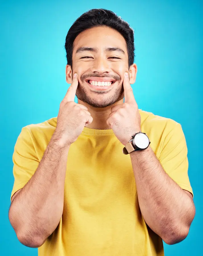

In [5]:
#Downloading the url of the pic:

from fastdownload import download_url
from urllib.error import ContentTooShortError
filename='smiling_person.jpg' #the filename for the downloaded image

download_url(urls[0], filename, show_progress=True) #show_progress shows the progress bar while downloading

from fastai.vision.all import *
image=Image.open(filename)
image.to_thumb(256,256) 
#to creat a preview of the pic we make a thumbnail version of the pic(max of 256×256 pixels) 
# this doesb't change the original image it's just for previewing

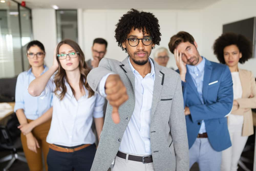

In [6]:
#Picture of a sad person:

download_url(searchimages('unhappy person', max_num=1)[0], 'unhappy_person.jpg', show_progress=False)
Image.open('unhappy_person.jpg').to_thumb(256,256)

In [ ]:
#Automatically do the process:

searches= 'unhappy person','smiling person'
path=Path('smiling_or_not') #the main folder where all images will be saved

for i in searches:
    allfilename=(path/i) #this will create a subfolder path like: smiling_or_not/unhappy person
    allfilename.mkdir(exist_ok=True, parents=True) #Making sure if the subfolder exists
    download_images(allfilename, urls=searchimages(f'{i} photo'))
    time.sleep(5) #resting 5 s between each category to avoid making too many requests at once
    #this makes training faster:
    resize_images(path/i, max_size=400, allfilename=path/i) #taking pics in the folder (path/i) Resizing them & replacing the originals with the resized versions

In [12]:
#Number of the images in each category
for i in searches:
    files = get_image_files(path/i)
    print(f"{i}: {len(files)} images")

unhappy person: 852 images
smiling person: 192 images


# Step 2: Train a model

In [13]:
#Avoiding bad urls or corrupted downloads:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

139

c:\Users\Maryam\miniconda3\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


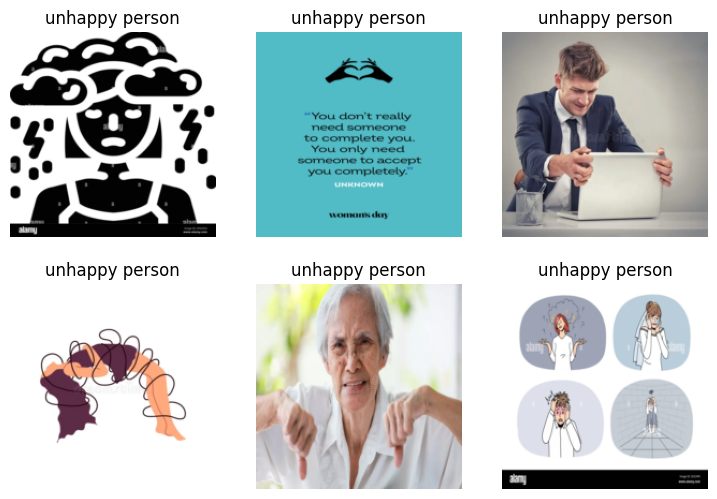

In [14]:
""" To train a model, we'll need DataLoaders, which is an object that contains a training set 
& a validation set. with fast.ai we make it by a DataBlock, and view sample images from it: """
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #the inputs:images & outputs(labels):categories 
    get_items=get_image_files, #a list of all image files in the path in dataloaders
    splitter=RandomSplitter(valid_pct=0.2, seed=42), #splitting the test set out: taking 20% of the data for the validation set
    get_y=parent_label, #using the name of each folder the image is in as its label
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32) 

dls.show_batch(max_n=6) #a example of 6 pics of the data and labels

In [15]:
#transfer learning : fine tuning a pre-trained model resnet18 (this model was originally trained on a huge dataset This means it already knows how to detect general visual features)
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)
"""finetune for the number of the epoches it takes (how many times the model should be run on the whole data)
adjust the weights downloaded & adjust it to our data to teach the model the difference between our data and the data that 
resnet18 has been trained on """

epoch,train_loss,valid_loss,error_rate,time
0,1.138700,0.675413,0.320442,05:52


c:\Users\Maryam\miniconda3\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.695138,0.573145,0.243094,03:19
1,0.521587,0.342440,0.132597,03:19
2,0.417674,0.275196,0.082873,03:04


'finetune for the number of the epoches it takes (how many times the model should be run on the whole data)\nadjust the weights downloaded & adjust it to our data to teach the model the difference between our data and the data that \nresnet18 has been trained on '

# Step 3: Test the model

In [16]:
#making a prediction on a new image called 'happy person.jpg'
is_smiling,_,probs = learn.predict(PILImage.create('smiling_person.jpg'))
print(f"This is a {is_smiling} with a probability of {probs[0]*100:.2f}%")


This is a smiling person with a probability of 100.00%
